DEAP (Distributed Evolutionary Algorithms in Python) é uma biblioteca de código aberto que facilita o desenvolvimento rápido e eficiente de algoritmos evolucionários e outros meta-heurísticos em Python.

Link: https://deap.readthedocs.io/en/master/

In [ ]:
# Instalação de biblioteca
!pip install deap

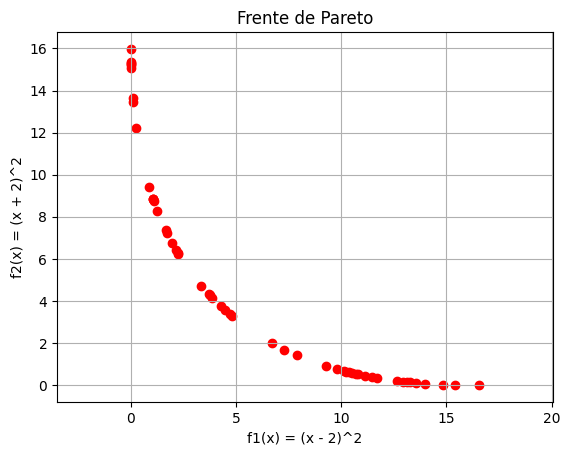

In [18]:
import random
from deap import base, creator, tools
import matplotlib.pyplot as plt

# Criação das classes de fitness e indivíduo
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimização de ambas as funções
creator.create("Individual", list, fitness=creator.FitnessMin)

# Registro dos atributos, indivíduo e população
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -5, 5)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Definição da função de avaliação
def evaluate(individual):
    x = individual[0]
    f1 = (x - 2)**2
    f2 = (x + 2)**2
    return f1, f2

toolbox.register("evaluate", evaluate)

# Registro dos operadores genéticos
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=-5, up=5, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=-5, up=5, eta=20.0, indpb=1.0)
toolbox.register("select", tools.selNSGA3)

# Geração dos pontos de referência para o NSGA-III
ref_points = tools.uniform_reference_points(nobj=2, p=12)

def main():
    # Inicialização da população
    population = toolbox.population(n=100)

    # Configurações do algoritmo
    NGEN = 250  # Número de gerações
    CXPB = 0.9  # Probabilidade de crossover
    MUTPB = 0.1  # Probabilidade de mutação

    # Avaliação inicial da população
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Loop evolutivo
    for gen in range(NGEN):
        # Seleção dos indivíduos
        offspring = toolbox.select(population, len(population), ref_points=ref_points)

        # Clonagem dos indivíduos selecionados
        offspring = list(map(toolbox.clone, offspring))

        # Aplicação do crossover e mutação
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values

        for ind in offspring:
            if random.random() <= MUTPB:
                toolbox.mutate(ind)
                del ind.fitness.values

        # Reavaliação dos indivíduos
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Atualização da população
        population = offspring

    # Extração da Frente de Pareto
    pareto_front = tools.sortNondominated(population, k=len(population), first_front_only=True)[0]

    return population, pareto_front

if __name__ == "__main__":
    population, pareto_front = main()

    # Plotagem da Frente de Pareto
    plt.figure()
    for ind in pareto_front:
        plt.scatter(ind.fitness.values[0], ind.fitness.values[1], c='r')
    plt.xlabel('f1(x) = (x - 2)^2')
    plt.ylabel('f2(x) = (x + 2)^2')
    plt.title('Frente de Pareto')
    plt.axis('equal')
    plt.grid()
    plt.show()


**pymoo** é uma biblioteca Python especializada em otimização multiobjetivo, oferecendo uma variedade de algoritmos e ferramentas para resolver problemas complexos com múltiplos objetivos de forma eficaz.

Link: https://pymoo.org/algorithms/moo/nsga3.html

In [ ]:
!pip install pymoo

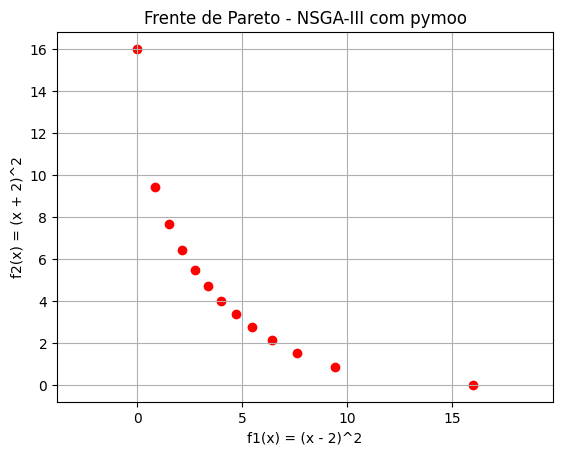

In [19]:
import numpy as np
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import matplotlib.pyplot as plt

# Definição do problema personalizado
class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=1,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([-5]),
                         xu=np.array([5]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = (x - 2)**2
        f2 = (x + 2)**2
        out["F"] = np.column_stack([f1, f2])

# Geração das direções de referência para o NSGA-III
ref_dirs = get_reference_directions("uniform", 2, n_partitions=12)

# Configuração do algoritmo NSGA-III
algorithm = NSGA3(pop_size=100, ref_dirs=ref_dirs)

# Definição do problema
problem = MyProblem()

# Execução da otimização
res = minimize(problem,
               algorithm,
               termination=('n_gen', 250),
               seed=1,
               verbose=False)

# Extração da Frente de Pareto
F = res.F

# Plotagem da Frente de Pareto
plt.figure()
plt.scatter(F[:, 0], F[:, 1], c='r')
plt.xlabel('f1(x) = (x - 2)^2')
plt.ylabel('f2(x) = (x + 2)^2')
plt.title('Frente de Pareto - NSGA-III com pymoo')
plt.axis('equal')
plt.grid()
plt.show()
